# Imports and definitions

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import matplotlib as mpl
from matplotlib import cm
from matplotlib.colors import rgb2hex
from scipy import constants
import sympy as sp

%matplotlib inline

mpl.rcParams['savefig.dpi'] = 150
mpl.rcParams['figure.dpi'] = 150
mpl.rcParams['figure.figsize'] = (3,2)
mpl.rcParams['font.size'] = 8
mpl.rcParams['font.family'] = 'Arial'
mpl.rcParams['savefig.transparent'] = False
mpl.rcParams['figure.facecolor'] = 'white'

# Todo

* include detuning between the dots

# Definitions

In [126]:
twopi = 2 * np.pi

### conversion tools
def volt2omega(V):
    return constants.e * V / (constants.hbar)


def dBm2pwr(dBm):
    return 1e-3 * 10**(dBm/10)
    

def pwr2dBm(pwr):
    return 10*np.log10(pwr/1e-3)


def pwr2photonflux(pwr, omega):
    return pwr / (constants.hbar * omega)


def dBm2photonflux(dBm, omega):
    return pwr2photonflux(dBm2pwr(dBm), omega)


def noisepwr(T_N, B, G):
    return constants.k * T_N * B * G


def reflection_hiQ(omega, domega, Q):
    """
    Compute the voltage reflection coefficient for the load being a high-Q resonator.
    Inputs:
        * omega : resonator frequency
        * domega : drive detuning from resonator frequency
        * Q : Q-factor of the oscillator
    """
    Gamma=(domega+1j*omega/(2*Q))/(domega-1j*omega/(2*Q))
    return Gamma

class QuantumCapacitance(object):
    
    default_params = dict()
    
    def __init__(self, **params):
        _p = self.default_params.copy()
        _p.update(params)
        for p in _p:
            setattr(self, p, _p[p])
            
    def Cq(self):
        return self.alpha**2 * constants.e**2 / (2 * constants.hbar * self.tau)

    def phase_offset_hiQ(self):
        """
        Compute the phase in reflection that is due to quantum capacitance.
        For Q >= 50, we use the high-Q approximation for the reflection coefficient,
        otherwise we use the standard formula or Voltage reflection and assume a simple series LC resonator.
        """
        omega = 1/np.sqrt(L*Cp)
        omega_q = 1/np.sqrt(L*(Cp+Cq))
        Gamma1 = reflection_hiQ(omega, 0, Q)
        Gamma2 = reflection_hiQ(omega, omega-omega_q, Q)
        phase1 = np.angle(Gamma1, deg=False)
        phase2 = np.angle(Gamma2, deg=False)
        return phase1 - phase2
    

class GatesensorResponse(object):
    
    default_params = dict(tau=0, alpha=0.1, C=1e-12,
                          omega=twopi*1e9, g0=0, Vg=0, domega=0, 
                          kappa_in=twopi*1e6, kappa_out=0, kappa_loss=0,
                          input=0, gamma=0)
    
    def __init__(self, **params):
        _p = self.default_params.copy()
        _p.update(params)
        for p in _p:
            setattr(self, p, _p[p])
            
    def gatevoltage_from_excitation(self, p_max=0.01):
        return ((p_max * (self.tau-self.omega)**2)/ ((constants.e/constants.hbar)**2 * (1.-p_max)))**(0.5)
            
    def gatevoltage_from_disp(self):
        return (constants.hbar * self.omega / self.C)**.5 * 2 * self.disp
    
    def disp_from_gatevoltage(self):
        return self.Vg * (self.C / constants.hbar / self.omega)**.5 / 2.

    def input_from_disp(self, g0=None):
        k = self.kappa_in + self.kappa_out + self.kappa_loss
        D = self.Delta_from_tau()
        if g0 is None:
            if not hasattr(self, 'g0'):
                g0 = self.g0_from_circuit()
            else:
                g0 = self.g0
        
        return self.disp * (self.domega - 1j*k/2 + g0**2/(-D + 1j * self.gamma)) / (-1j*(self.kappa_in)**.5)
    
    def disp_from_input(self, g0=None):
        k = self.kappa_in + self.kappa_out + self.kappa_loss
        D = self.Delta_from_tau()
        if g0 is None:
            if not hasattr(self, 'g0'):
                g0 = self.g0_from_circuit()
            else:
                g0 = self.g0
        
        top = -1j * self.kappa_in**.5 * self.input
        bottom = self.domega - 1j*k/2.
        try:
            bottom += g0**2 / (-D + 1j*self.gamma)
        except ZeroDivisionError:
            pass
        return  top / bottom
    
    def Delta_from_tau(self):
        return self.tau - self.omega

    def g0_from_circuit(self):
        return constants.e * self.alpha * (constants.hbar * self.omega / self.C)**.5 / constants.hbar / 2.

    def transmission(self, *arg, **kw):
        return - self.kappa_out**.5 * self.disp_from_input(*arg, **kw)
    
    def reflection(self, *arg, **kw):
        return - self.kappa_in**.5 * self.disp_from_input(*arg, **kw) + self.input
#         return self.transmission(*arg, **kw) - self.input

    def phaseshift_r(self):
        r0 = get_reflection()
        r1 = get_reflection(g0=0)
        return np.angle(r0) - np.angle(r1)

    def phaseshift_t(self):
        r0 = get_transmission()
        r1 = get_transmission(g0=0)
        return np.angle(r0) - np.angle(r1)

# Sanity checking the code

In [127]:
gr = GatesensorResponse(domega=0, kappa_in=1, kappa_out=0, input=1)
print(gr.disp_from_input())

gr.disp = 1
print(gr.input_from_disp())

(2-0j)
(0.5-0j)


## Phase roll in reflection and transmission

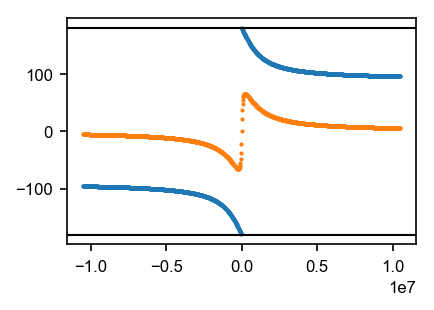

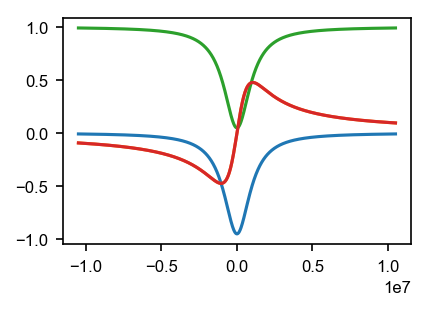

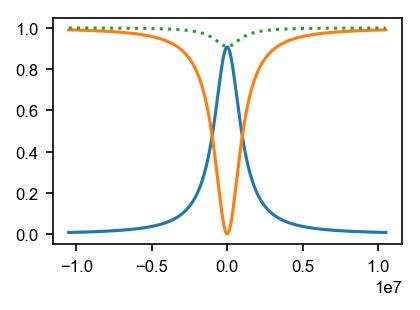

In [129]:
k_in = twopi*1e6
k_out = twopi*1e6
k_loss = twopi*0.1e6
k = k_in + k_out + k_loss

gr = GatesensorResponse(omega=twopi*7e8, tau=twopi*1e10, alpha=0.8, C=0.3e-12,
                        kappa_in=k_in, kappa_out=k_out, kappa_loss=k_loss, input=1)
gr.domega = 5 * np.linspace(-k, k, 1001)

t1 = gr.transmission()
r1 = gr.reflection()

fig, ax = plt.subplots(1,1)
ax.plot(gr.domega / twopi, np.angle(t1, deg=True), 'o', ms=1)
ax.plot(gr.domega / twopi, np.angle(r1, deg=True), 'o', ms=1)
ax.axhline(-180, color='k', lw=1)
ax.axhline(180, color='k', lw=1)

fig, ax = plt.subplots(1,1)
ax.plot(gr.domega / twopi, t1.real)
ax.plot(gr.domega / twopi, t1.imag)
ax.plot(gr.domega / twopi, r1.real)
ax.plot(gr.domega / twopi, r1.imag)

fig, ax = plt.subplots(1,1)
ax.plot(gr.domega / twopi, np.abs(t1)**2)
ax.plot(gr.domega / twopi, np.abs(r1)**2)
ax.plot(gr.domega / twopi, np.abs(r1)**2 + np.abs(t1)**2, ':')

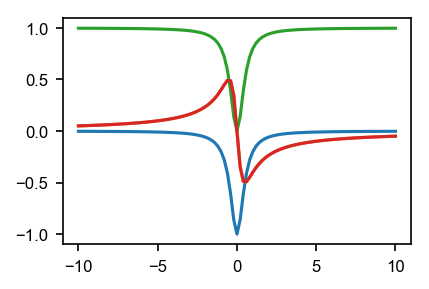

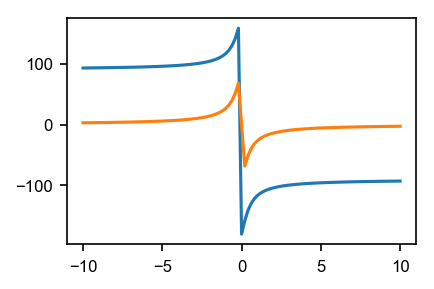

In [113]:
k = 1
domega = np.linspace(-10,10,101)
ain = 1

aout_r = k/2. / (1j * domega - k/2.) * ain
aout_l = 1j * domega / (1j * domega - k/2) * ain

fig, ax = plt.subplots(1,1)
ax.plot(domega, aout_r.real)
ax.plot(domega, aout_r.imag)
ax.plot(domega, aout_l.real)
ax.plot(domega, aout_l.imag)

fig, ax = plt.subplots(1,1)
ax.plot(domega, np.angle(aout_r, deg=True))
ax.plot(domega, np.angle(aout_l, deg=True))

## Try to reproduce phase shift from Petersson, 2012

In [ ]:
C = 2e-12
tau = twopi * 7e9
alpha = 0.2
omega = twopi * 6200e6
Q = 2000

Delta = tau - omega
kappa = omega / Q
detvals = 5 * np.linspace(-kappa, kappa, 501)
g = get_g0(alpha, omega, C)
print(g * 1e-6 / twopi)

# t1 = get_transmission(detvals, kappa/10., kappa, 1., 0, Delta, 0)
# r1 = get_reflection(detvals, kappa, 0, 1., 0, Delta, 0)

dphi1 = get_phaseshift_r(detvals, kappa, 0, 1, g, Delta, 0 * twopi * 1e9)
dphi2 = get_phaseshift_t(detvals, kappa/100., kappa, 1, g, Delta, 0 * twopi * 1e9)

fig, ax = plt.subplots(1,1)
ax.plot(detvals / twopi * 1e-6, dphi1 * 180/np.pi, label='R')
ax.plot(detvals / twopi * 1e-6, dphi2 * 180/np.pi, label='T')
ax.legend(loc='lower right', fontsize='small')
ax.set_xlabel('Drive detuning (MHz)')
ax.set_ylabel('Phase shift (deg)')

In [ ]:
C = 0.3e-12
alpha = 0.8
omega = twopi * 0.6e9
Q = 50
domega = 0

# derived vals
kappa = omega / Q
g = get_g0(alpha, omega, C)

# grid vals
tauvals = twopi * np.linspace(1e9, 20e9, 101)
Deltavals = tauvals - omega

fig, ax = plt.subplots(1,1)
for gamma in np.pi * np.linspace(0, 10e9, 6):
    dphivals = get_phaseshift_r(domega, kappa, 0, 1, g, Deltavals, gamma)
    ax.plot(tauvals/twopi * 1e-9, dphivals * 180/np.pi, 
            label='$\gamma/\pi$ = {:.0f} GHz'.format(gamma/np.pi * 1e-9))
    
ax.set_ylim(-180, 0)
ax.set_xlabel('Tunnel coupling (GHz)')
ax.set_ylabel('Phase shift (deg)')
ax.legend(loc='lower right', fontsize='small')

## Colless

In [ ]:
C = 0.23e-12
alpha = 0.05
omega = twopi * 0.7e9
Q = 70
domega = 0

# derived vals
kappa = omega / Q
g = get_g0(alpha, omega, C)
L = 1/(omega**2*C)

# sweep vals
tauvals = twopi * np.linspace(10e9, 20e9, 20)
Deltavals = tauvals - omega
Cq_vals = get_Cq(alpha, tauvals-)

dphivals_Cq = phase_offset_hiQ(L, C, Cq_vals, Q)
dphivals = get_phaseshift_r(domega, kappa, 0, 1, g, Deltavals, 0)


fig, ax = plt.subplots(1,1)
ax.plot(tauvals/twopi * 1e-9, abs(dphivals * 180/np.pi))
ax.plot(tauvals/twopi * 1e-9, abs(dphivals_Cq * 180/np.pi))

ax.set_xlabel('Tunnel coupling (GHz)')
ax.set_ylabel('Phase shift (deg)')

In [ ]:
Cq = get_Cq(alpha, twopi * 16e9)
print(Cq)